In [1]:
import sys
sys.path.append("../src")
import torch
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torch.nn.functional as F

import glob
import os
from datetime import datetime
import time
import math
from tqdm import tqdm

from itertools import repeat
from torch.nn.parameter import Parameter
import collections
import matplotlib
from torch_utils import *
from models import *
from visualization import *
# matplotlib.use('Agg')

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [3]:
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(), 
                                            torchvision.transforms.Normalize(mean=(0.0,), 
                                            std=(1.0,))])

cifar_dset_train = torchvision.datasets.CIFAR10('./data', train=True, transform=transform, target_transform=None, download=True)
train_loader = torch.utils.data.DataLoader(cifar_dset_train, batch_size=20, shuffle=True, num_workers=0)

cifar_dset_test = torchvision.datasets.CIFAR10('./data', train=False, transform=transform, target_transform=None, download=True)
test_loader = torch.utils.data.DataLoader(cifar_dset_test, batch_size=20, shuffle=False, num_workers=0)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
activation_type = "tanh"
architecture = [32*32*3, 1000, 500, 10]

x,y = next(iter(train_loader))
x = x.view(x.size(0),-1).to(device).T
y_one_hot = F.one_hot(y, 10).to(device).T
lambda_ = 0.9999
epsilon = 0.1#0.5
neural_lr_start = 0.1/25
neural_lr_stop = 0.0001
neural_lr_rule = "constant"
neural_lr_decay_multiplier = 0.01
neural_dynamic_iterations = 50

lr_start = {'ff' : 0.001, "fb": 0.0005}
# lr_start = {'ff' : 0.001, "fb": 0.001}

model = CorInfoMaxV2(architecture, lambda_, epsilon, activation_type)

In [5]:
trn_acc_list = []
tst_acc_list = []

n_epochs = 10
lr = lr_start
for epoch_ in range(n_epochs):
    lr = {'ff' : lr_start['ff'] * (0.9)**epoch_, 'fb' : lr_start['fb'] * (0.9)**epoch_}
    for idx, (x, y) in tqdm(enumerate(train_loader)):
        x, y = x.to(device), y.to(device)
        x = activation_inverse(x.view(x.size(0),-1).T, activation_type)
        #x = x.view(x.size(0),-1).T
        y_one_hot = F.one_hot(y, 10).to(device).T
        y_one_hot = 0.94 * y_one_hot + 0.03 * torch.ones(*y_one_hot.shape, device = device)
        _ = model.batch_step( x, y_one_hot, lr, neural_lr_start, neural_lr_stop, neural_lr_rule,
                              neural_lr_decay_multiplier, neural_dynamic_iterations, optimizer = "sgd"
                            )

    trn_acc = evaluatePC(model, train_loader, device, activation_type = activation_type, printing = False)
    tst_acc = evaluatePC(model, test_loader, device, activation_type = activation_type, printing = False)
    trn_acc_list.append(trn_acc)
    tst_acc_list.append(tst_acc)
    
    print("Epoch : {}, Train Accuracy : {}, Test Accuracy : {}".format(epoch_+1, trn_acc, tst_acc))

2500it [03:17, 12.66it/s]
3it [00:00, 20.51it/s]

Epoch : 1, Train Accuracy : 0.29398, Test Accuracy : 0.2876


2500it [02:06, 19.80it/s]
3it [00:00, 21.08it/s]

Epoch : 2, Train Accuracy : 0.3286, Test Accuracy : 0.3245


2500it [02:00, 20.81it/s]
2it [00:00, 19.98it/s]

Epoch : 3, Train Accuracy : 0.32556, Test Accuracy : 0.3199


2500it [02:01, 20.65it/s]
3it [00:00, 21.89it/s]

Epoch : 4, Train Accuracy : 0.3366, Test Accuracy : 0.335


2500it [02:01, 20.63it/s]
2it [00:00, 18.21it/s]

Epoch : 5, Train Accuracy : 0.33814, Test Accuracy : 0.3325


2500it [02:09, 19.24it/s]
2it [00:00, 19.64it/s]

Epoch : 6, Train Accuracy : 0.33554, Test Accuracy : 0.3281


2500it [02:15, 18.44it/s]
3it [00:00, 21.59it/s]

Epoch : 7, Train Accuracy : 0.34664, Test Accuracy : 0.3442


2500it [02:11, 18.97it/s]
3it [00:00, 18.95it/s]

Epoch : 8, Train Accuracy : 0.34282, Test Accuracy : 0.3388


2500it [02:01, 20.63it/s]
3it [00:00, 20.03it/s]

Epoch : 9, Train Accuracy : 0.34938, Test Accuracy : 0.3452


2500it [02:07, 19.66it/s]


Epoch : 10, Train Accuracy : 0.347, Test Accuracy : 0.3427


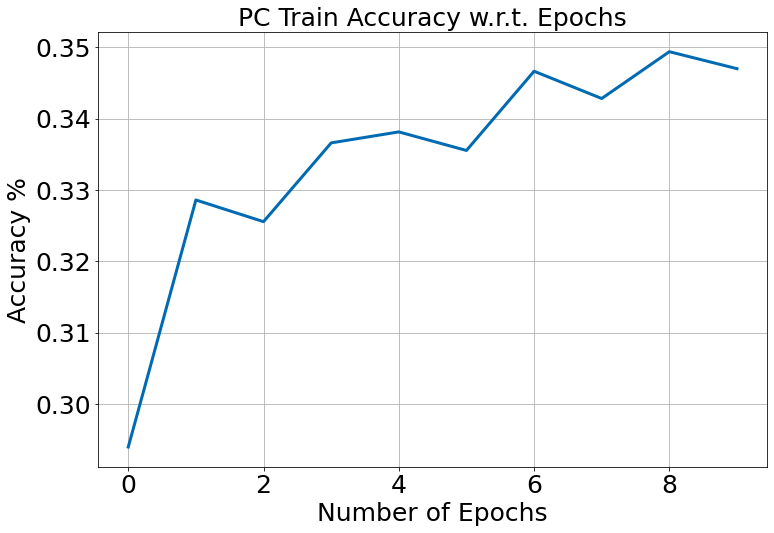

In [6]:
plot_convergence_plot(trn_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'PC Train Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

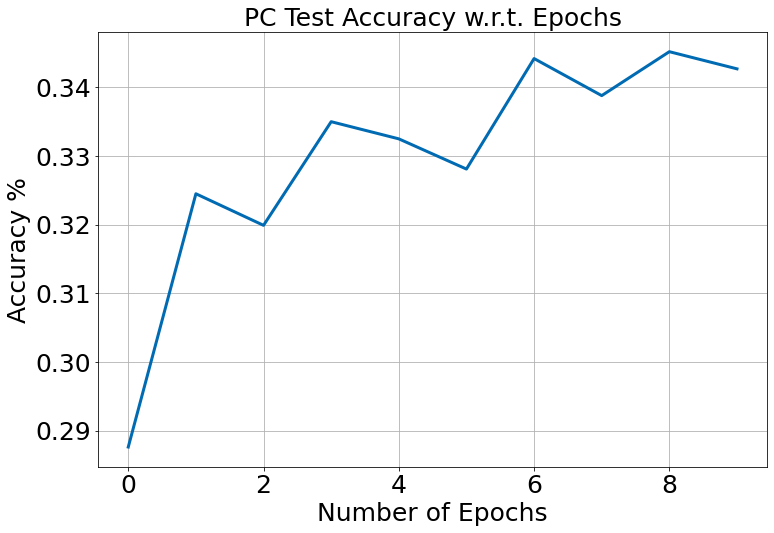

In [7]:
plot_convergence_plot(tst_acc_list, xlabel = 'Number of Epochs', ylabel = 'Accuracy %',
                      title = 'PC Test Accuracy w.r.t. Epochs', 
                      figsize = (12,8), fontsize = 25, linewidth = 3)

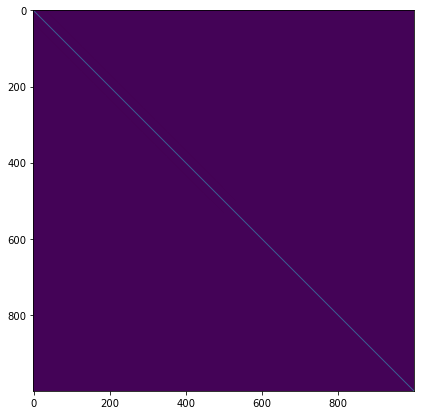

In [8]:
plt.figure(figsize = (7,7))
plt.imshow(torch2numpy(model.B[0]["weight"]))

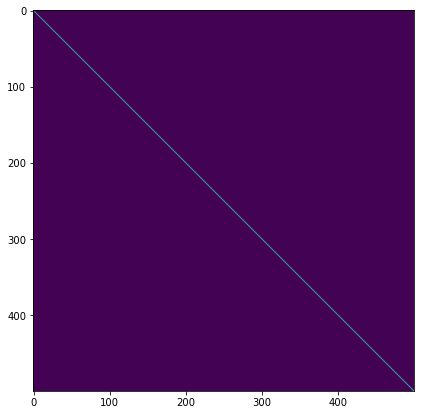

In [9]:
plt.figure(figsize = (7,7))
plt.imshow(torch2numpy(model.Bsigma[1]["weight"]))

In [10]:
model.Bsigma[1]["weight"]

tensor([[ 1.1893e+00, -2.0459e-03, -2.3108e-03,  ..., -8.0832e-05,
         -1.4437e-04, -1.6806e-04],
        [-2.0459e-03,  1.1904e+00, -1.2870e-04,  ..., -1.9374e-04,
         -2.0936e-04, -2.1309e-04],
        [-2.3108e-03, -1.2870e-04,  1.1932e+00,  ..., -1.0057e-04,
         -1.0038e-04, -7.2082e-05],
        ...,
        [-8.0832e-05, -1.9374e-04, -1.0057e-04,  ...,  1.2176e+00,
         -6.5524e-04, -6.2817e-05],
        [-1.4437e-04, -2.0936e-04, -1.0038e-04,  ..., -6.5524e-04,
          1.2175e+00, -6.4780e-04],
        [-1.6806e-04, -2.1309e-04, -7.2082e-05,  ..., -6.2817e-05,
         -6.4780e-04,  1.2175e+00]], device='cuda:0')